In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import sys
# add root folder to path
folder = "../../"
sys.path.append(folder)
from src.utils import load_data
from src.utils import plot_metrics_grid
from src.utils import load_baseline_rec_result
from src.metrics import evaluate_recommender_system

In [3]:
users,ratings,movies = load_data('../../data/ml-1m')

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

cutoff_date = ratings['timestamp'].quantile(0.8)  # 80% of the data for training, 20% for testing
train_ratings = ratings[ratings['timestamp'] <= cutoff_date]
test_ratings = ratings[ratings['timestamp'] > cutoff_date]

train_movie_ids = train_ratings['movie_id'].unique()
test_movie_ids = test_ratings['movie_id'].unique()

train_movies = movies[movies['movie_id'].isin(train_movie_ids)]
test_movies = movies[movies['movie_id'].isin(test_movie_ids)]

# Ensure the indices are reset to avoid out of bound errors
train_movies = train_movies.reset_index(drop=True)
test_movies = test_movies.reset_index(drop=True)

In [4]:
title_to_index = pd.Series(train_movies.index, index=train_movies['title']).drop_duplicates()

tfidf = TfidfVectorizer(stop_words='english')
train_movies['genres'] = train_movies['genres'].fillna('')
tfidf_matrix = tfidf.fit_transform(train_movies['genres'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [5]:
def get_recommendations(title, cosine_sim=cosine_sim, n=10):
    if title not in title_to_index:
        return []
    idx = title_to_index[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]

    return train_movies['title'].iloc[movie_indices]


print(get_recommendations('Toy Story (1995)'))

980             Aladdin and the King of Thieves (1996)
1935                          American Tail, An (1986)
1936        American Tail: Fievel Goes West, An (1991)
2132                         Rugrats Movie, The (1998)
2133                              Bug's Life, A (1998)
2867                                Toy Story 2 (1999)
3333                             Saludos Amigos (1943)
3468                                Chicken Run (2000)
3471    Adventures of Rocky and Bullwinkle, The (2000)
12                                        Balto (1995)
Name: title, dtype: object


In [9]:
def get_user_recommendations(user_id, n=25):
    user_ratings = train_ratings[train_ratings['user_id'] == user_id]
    high_rated_movies = user_ratings[user_ratings['rating'] >= 4]['movie_id']
    high_rated_titles = train_movies[train_movies['movie_id'].isin(high_rated_movies)]['title']
    recommendations = pd.Series(dtype='object')
    for title in high_rated_titles:
        recs = get_recommendations(title)
        recommendations = pd.concat([recommendations, recs])
    recommendations = recommendations[~recommendations.isin(high_rated_titles)].drop_duplicates()

    return recommendations.head(n)

user_id = 635
print(f'Recommendations for User {user_id}:')
print(get_user_recommendations(user_id))

Recommendations for User 635:
276                           New Jersey Drive (1995)
281                         Once Were Warriors (1994)
381                              Jason's Lyric (1994)
414                              Carlito's Way (1993)
784                                      Cyclo (1995)
802                Killer: A Journal of Murder (1995)
884                       Angel on My Shoulder (1946)
886                    They Made Me a Criminal (1939)
970                                Normal Life (1996)
307                                   Stargate (1994)
319                     Star Trek: Generations (1994)
1241                  Star Trek: First Contact (1996)
1253             Star Trek: The Motion Picture (1979)
1254    Star Trek VI: The Undiscovered Country (1991)
1255           Star Trek V: The Final Frontier (1989)
1256              Star Trek: The Wrath of Khan (1982)
1257       Star Trek III: The Search for Spock (1984)
1258             Star Trek IV: The Voyage Home (1986

/Users/pavlo.borysenko/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/pavlo.borysenko/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


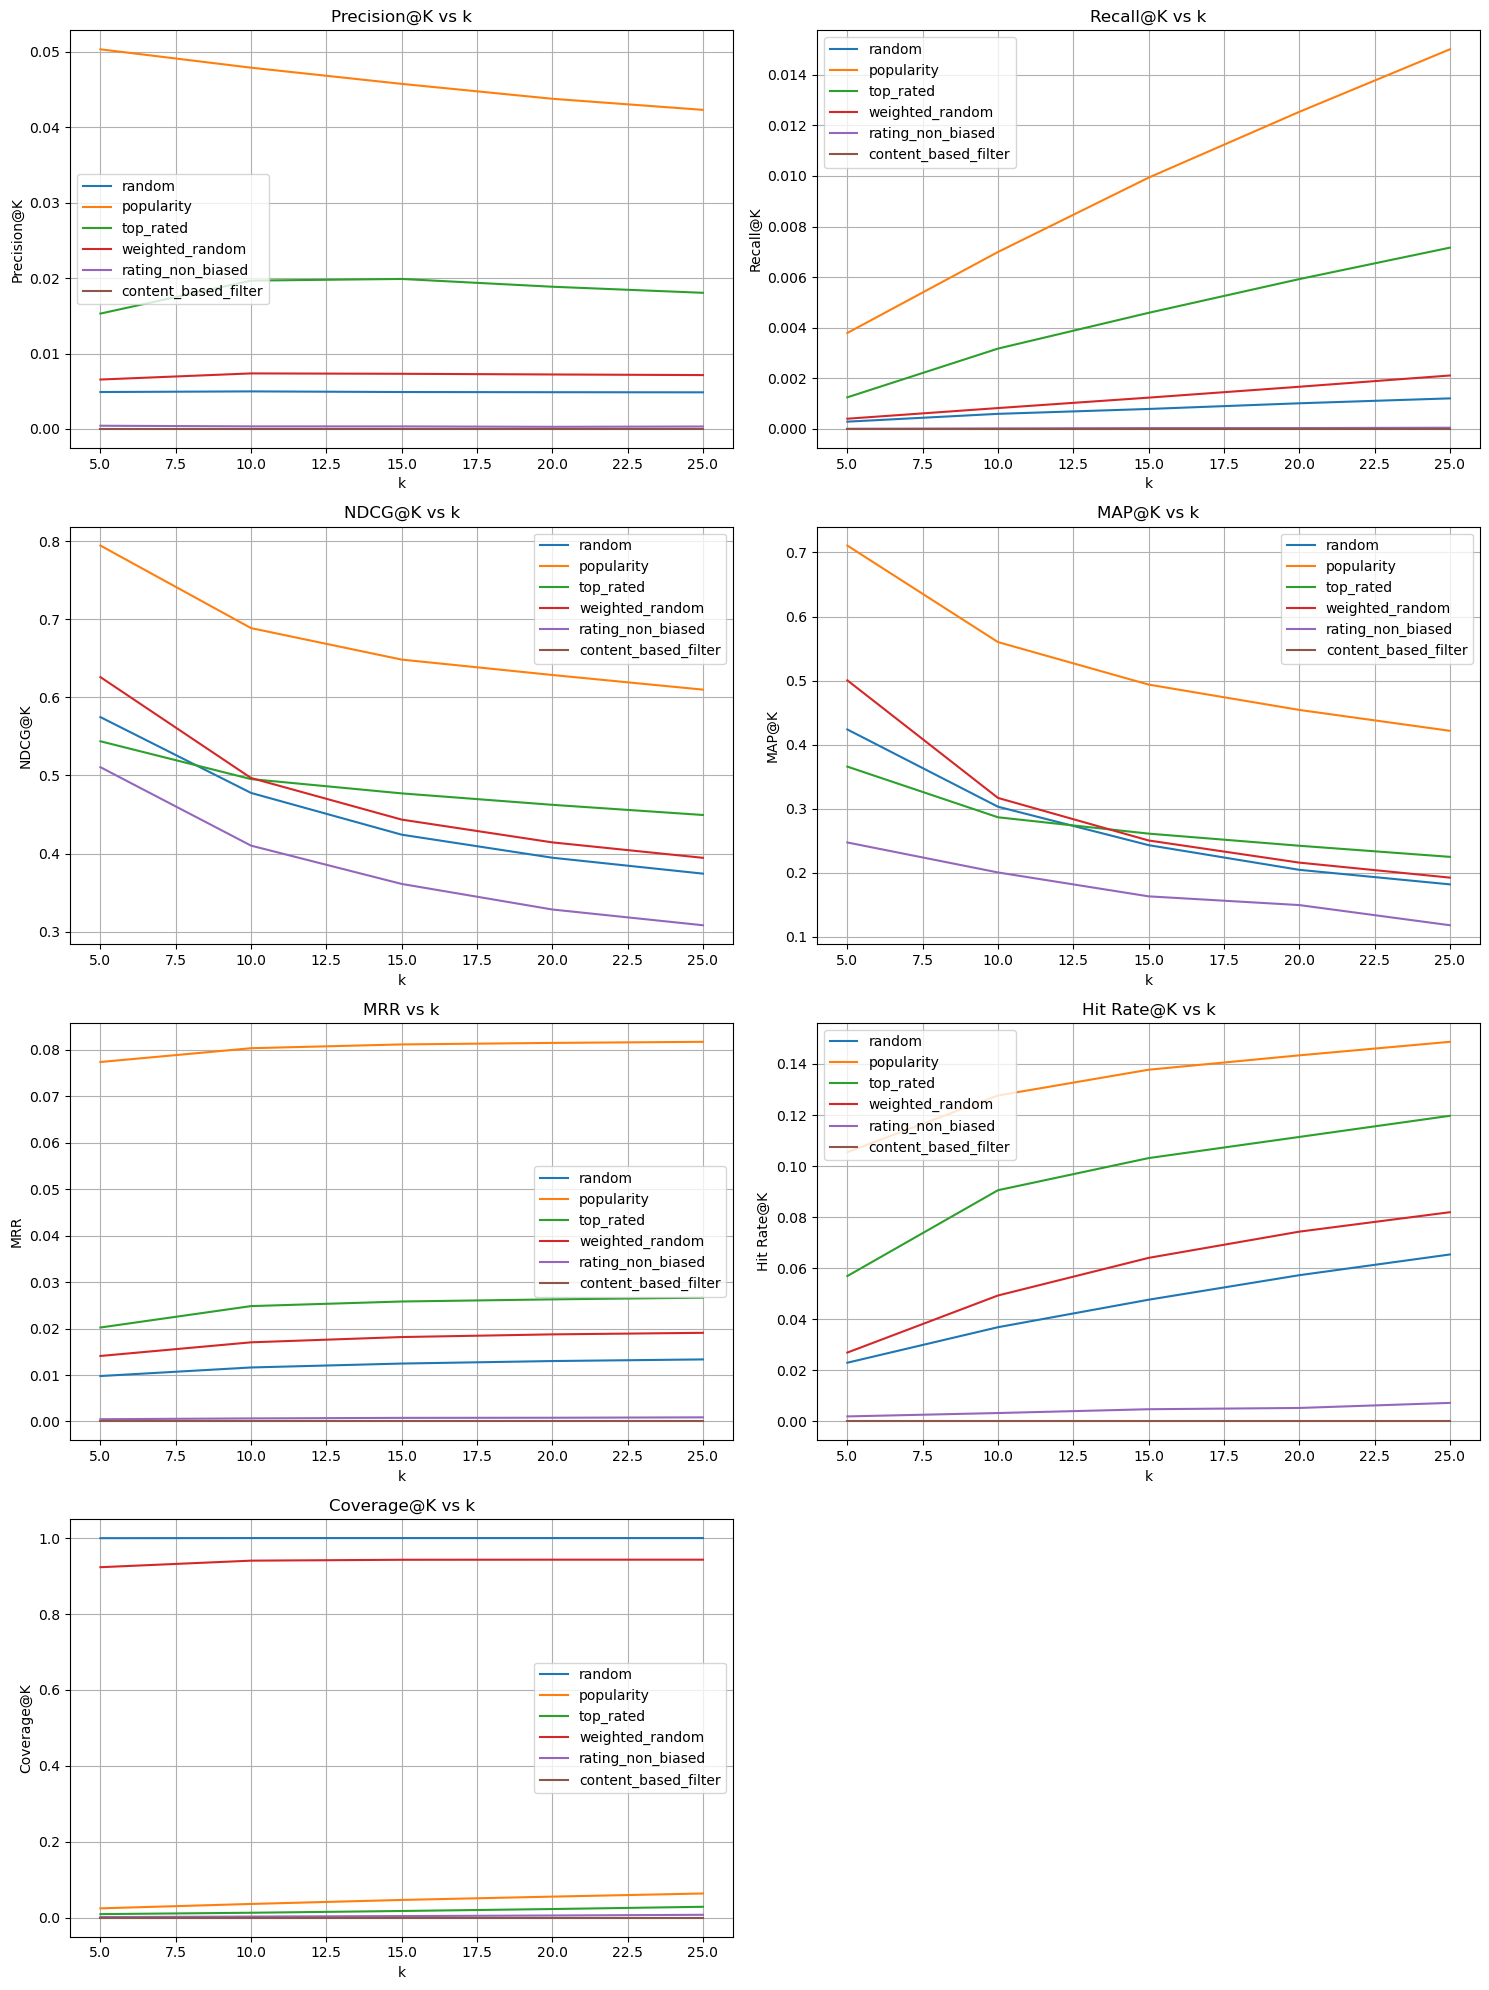

In [11]:
metrics_results = {}
base_line_metrics = load_baseline_rec_result()
recommendations = {}
for user_id in test_ratings['user_id'].unique():
    recommendations[user_id] = get_user_recommendations(user_id, 25)
for i in range(5, 26, 5):
    metrics_results[i] = evaluate_recommender_system(dict(list(recommendations.items())[:10]), test_ratings, len(movies),i)

combined = base_line_metrics | {'content_based_filter': metrics_results}
metrics = ['Precision@K', 'Recall@K', 'NDCG@K', 'MAP@K', 'MRR', 'Hit Rate@K', 'Coverage@K']
plot_metrics_grid(combined, metrics)